<h1> BBHs merging catalog generator 4.2 </h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from multiprocessing import Pool, Manager, Value
from functools import partial
#from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

mode_ex = False
mode_fastmc = False
mode_poisson = False
Red_evol = False
SNR_Cut = False
sel_rs = False

# Number of jobs spawned by the multiprocessing part of the program (use 9/10 * number of core to avoid problems)

n_jobs = 80#(mp.cpu_count() - 4)

# To avoid to saturate the ram when copying the generated list to a dataframe, the process will be made by slicing the list in percentage

cp_perc = 0.01 # If ram > 16 GB put cp_perc = 1 to do the copy in one single step

# Merger distribution parameters

T_obs = 3. # Lisa estimated years of observation
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc

T_tot = max_tc

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
H_0 = 67.8 # Hubble constant in Km/(s*MPc)
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

mass_prec = 750           # Binning density for the masses
z_prec = 500              # Binning density for the redshift (affect distance density)

<h2> FLAG selection section </h2>

The standard way of simulating the events will generate the same number of events in the same range of variables every time it was run...
To give to the simulation a little bit of randomness, and allow the generation of merging events with exotic range of variable, set the **exotic_mode** flags to true. 

In [3]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one mode flag may be setup at a single time !**

In [4]:
#mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

Or we can simulate the number of events in each phase space bin by using a poisson distribution, to do this we need to set the **mode_poisson** flag to true :

In [ ]:
mode_poisson = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [5]:
Red_evol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume

Lastly, we may set the flag SNR_Cut if we wish to simulate only events with chirpmass bigger than the value defined by the SNR_Cutoff functions, this will only generate events with SNR bigger then the imposed treshold value :

In [6]:
#SNR_Cut = True # If true only events resulting in an SNR bigger than the imposed cutoff would appear in the final catalogue

Furthermore, you may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [7]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

<h2> Mass distribution functions </h2>

Let's start by defining the probability distribution in function of the masses.

We have :

In [8]:
# Model B mass distribution function of the paper arxiv 1811.12940

# Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

#m_min = 5. # Solar Masses
#m_max = 50. # Solar Masses
#alpha = 1.6 # +-1.6 Big Error !
#beta_q = 6.7 # +4.8 -5.9 Still Big Error !

# Function for estimating the Phase Space costant of the Mass distribution

#def ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
#    
#    ris = 0.
#    
#    for i in range(len(ran_m1)- 1):
#        for j in range(len(ran_m2)- 1):
#            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
#                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
#                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
#                q = mid_m2/mid_m1 
#                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
#   
#    return ris

# Function for the distribution in function of mass (as used in paper arxiv 1811.12940)

#def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
#    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
#        q = m2/m1
#        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
#    else :
#        return 0.

In [9]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

# Mass Distribution parameters (values taken from the results of arxiv 2010.14533)

m_min = 5. # Solar Masses (in the paper 4.53 + 1.47 - 1.89 Solar Masses)
m_max = 100. # Solar Masses (in the paper 86.73 + 11.56 - 12.37 Solar Masses)
alpha = 2.62 # +0.73 - 0.62
beta_q = 1.26 # +2.37 -1.62 
delta_m = 4.88 # + 4.10 -4.25 Solar Masses 
lambda_peak = 0.10 # +0.14 -0.07 
mu_m = 33.49 # +4.54 -5.51 Solar Masses
sigma_m = 5.09 # +4.28 - 4.34 Solar Masses

# Defining of the smoothing function for m close to the minimimum mass

def MassSmoothing(m, m_min, delta_m):
    if(m < m_min):
        return 0.
    else:
        if(m >= (m_min + delta_m)):
            return 1.
        else:
            factor = np.exp((delta_m/(m - m_min)) + (delta_m/(m - m_min - delta_m)))
            return 1./(factor + 1.)

# Defining a normalized power law distribution function, needed for the final distribution function        
        
def MassPowLaw(m, m_min, m_max, alpha, PL_norm):
    if(m_min < m < m_max):
        return (1./PL_norm)*(m**(-alpha))
    else:
        return 0.
    
# Estimating the Phase space of the Power law distribution using trapezoidal integration
    
def PowerLawPS(ran_m1, m_min, m_max, alpha):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
       if(ran_m1[i] >= m_min and ran_m1[i] <= m_max):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(np.power(mid_m1, (-alpha)))
   
    return ris

    
# Defining a Gaussian distribution of the mass, needed for the final distribution function

def MassGauss(m, mu_m, sigma_m, GS_norm):
    return ((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-mu_m)/sigma_m)**2.))*1./GS_norm

def GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
       if(ran_m1[i] >= m_min and ran_m1[i] <= m_max):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                ris +=  (ran_m1[i + 1] - ran_m1[i])*((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((mid_m1-mu_m)/sigma_m)**2.))
   
    return ris


# Defining the normalization constant for the q dependancy of the total mass distribution

def P2PS(ran_m2, beta_q, m_min, delta_m):
    
    q_norm = np.linspace(0,1,len(ran_m2))
    
    for i in range(len(ran_m1) - 1):
        
        q_norm[i] = 0.
        
        for j in range(i + 1):
            
            q_norm[i] += ((0.5*(ran_m2[j] + ran_m2[j + 1])/(0.5*(ran_m2[i] + ran_m2[i + 1])))**(beta_q))*\
            (ran_m2[j + 1] - ran_m1[j])*MassSmoothing(0.5*(ran_m2[j] + ran_m2[j + 1]), m_min, delta_m)
    
    
    q_norm[len(ran_m1) - 1] = q_norm[len(ran_m1) - 2]
    
    return q_norm   
    

# Defining the proper Mass distribution function

def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm, Mass_PS):
    
    if(m1 > m2):
        return ((1. - lambda_peak)*MassPowLaw(m1, m_min, m_max, alpha, PL_norm) + \
                lambda_peak*MassGauss(m1, mu_m, sigma_m, GS_norm))*MassSmoothing(m1, m_min, delta_m)*\
                ((m2/m1)**(beta_q))*(1./q_norm)*MassSmoothing(m2, m_min, delta_m)*(1./Mass_PS)
    else:
        return 0.


# Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

def ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm, Mass_PS):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
        for j in range(len(ran_m2)- 1):
             if(ran_m1[i] >= ran_m2[j]):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
                q = mid_m2/mid_m1 
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*((1. - lambda_peak)\
                *MassPowLaw(mid_m1, m_min, m_max, alpha, PL_norm) + lambda_peak*MassGauss(mid_m1, mu_m, sigma_m, GS_norm))\
                *MassSmoothing(mid_m1, m_min, delta_m)*(q**(beta_q))*(1./q_norm[i])*MassSmoothing(mid_m2, m_min, delta_m)\
                *(1./Mass_PS)
   
    return ris
    

and we will also need a function that return the Chirp Mass, given the mass of the two events involved in the binary merging :

In [10]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

<h2> Redshift dependent statistic </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [11]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

Omega_m = 0.3
Omega_lambda = 0.7
Omega_k = 0.
zmin = 1.e-5 # to avoid SNR divergence due to extremely close events
zmax_log = 0.1 # max z value generated in log scale
zmax_lin = 1.0 # max z value generated in lin scale


def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)))
    
        return Int_Z
    
        

and the function that estimates the differential comoving volume in function of the redshift :

In [12]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = Z_to_Gpc(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = Z_to_Gpc(z_2) - Z_to_Gpc(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

We may now define, the merging rate as a function of the redshift _z_ as :

In [13]:
# Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

#def R(z):
#    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [14]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

Corr_Rz = 1.01143
k = 1.3 # +2.1 - 2.1 VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION

# Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

R_0 = {}
R_0[0] = 19.1 # +16.2 - 9.0 GPc^-3 yr⁻1
R_0[1] = 23.9 # +14.9 - 8.6 GPc^-3 yr^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

def R(z):
    if(Red_evol):
        # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
        return R_0[0]*Corr_Rz*((1. + z)**k)/(1. + ((1. + z)/2.9)**(k + 2.9))
    else:
        return R_0[1]        


In order to better smoothen up the redshift distribution of the generated events, we will use the inverse uniform sampling instead of the normal uniform smoothing for the latters :

In [15]:
# Generating the inverse uniform sampling function, as described by Jesus Torrado

zs = np.logspace(np.log10(zmin), np.log10(zmax_log), z_prec*2)
zs = np.append(zs, np.linspace(zmax_log + (zs[(z_prec*2) - 1] - zs[(z_prec*2) - 2]), zmax_lin, z_prec*30))
rs = np.array([Z_to_Gpc(z) for z in zs])
vols = 4/3 * np.pi * rs**3
spl = interpolate.splrep(zs, vols)
Vz = lambda z: interpolate.splev(z, spl, der=0)
DerVz = lambda z: interpolate.splev(z, spl, der=1)

def pdf_z(z):
    return R(z)*DerVz(z) * (T_tot /(1. + z))

# Estimating the cumulative distribution functions value

ZCDF_samples = np.array([quad(pdf_z, 0, z)[0] for z in zs])

<h2> Spin distribution functions </h2>

Now let's define the spin amplitude distribution function as a Beta function (Default Spin of the cited paper) :

In [16]:
#Spin Amplitude Distribution parameter (values taken from the paper arxiv 2010.14533)

Expected_a = 0.25 # +0.09 - 0.07
Var_a = 0.03  # +0.02 - 0.01
a_max = 1.


def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')
else:
     print(r'We obtained $alpha_a = $ ',alpha_a, r'and $beta_a = $', beta_a)

# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

# Defining the inverse cumulative function for the spin amplitudes

spinamp_sample = lambda N, a, b: scst.beta(a, b).rvs(N)

We obtained $alpha_a = $  1.3125 and $beta_a = $ 3.9375000000000004


For what concerns the spin tilt distribution, we will implement a mixture between a Gaussian and an isotropic function (default spin of the cited paper):

In [17]:
#Spin tilt Distribution parameters (values assumed considering the results of arxiv 2010.14533, see equation (6) of 1811.12940 for additional information)

sigma_1 = 0.80 # + 1.08 - 0.45
sigma_2 = 0.80 # + 1.08 - 0.45
zeta = 0.76 # + 0.22 - 0.45

# Spin orientation distribution, zeta = 1 gives a gaussian distribution centered in cos_ti = 1, zeta = 0 will return a isotropic distribution

def SpinOrientDistrib(cos_t1,cos_t2, zeta, sigma_1, sigma_2):
    prob = (1. - zeta)/(4) + ((2.*zeta)/(np.pi))*\
    (np.exp(-((np.power(1. - cos_t1,2.))/(2.*np.power(sigma_1,2.))))/(sigma_1*sc.erf(np.sqrt(2)/sigma_1)))\
    *(np.exp(-((np.power(1. - cos_t2,2.))/(2.*np.power(sigma_2,2.))))/(sigma_2*sc.erf(np.sqrt(2)/sigma_2)))
    return prob

we are going to implement the Inverse cumulative distribution function _ICDF_ even for this _PDF_ , this may be trivially done considering the symmetry of the previous _PDF_ for exchange $cos(t_1) \rightarrow cos(t_2)$.
Let's start by estimating the values over the phase space :

In [18]:
Z = np.zeros((2000,2000))
ran_cos_t1 = np.linspace(-1.,1.,2000)
ran_cos_t2 = np.linspace(-1.,1.,2000)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1)):
    for j in range(len(ran_cos_t2)):
        
        Z[j][i] = SpinOrientDistrib(X[j][i], Y[j][i], zeta, sigma_1, sigma_2)

We may now marginalize over $cos(t_2)$ to obtain $P(cos(t_1))$, due to the simmetry in the _PDF_ the latter would be equal to $P(cos(t_2))$, and hence we may estimate the common _ICDF_ on the cumulative function of the first:

In [19]:
Int_Val = np.linspace(0,1,2000) # Array for the marginalization of the spin tilt distribution over cos(t2)
Cum_Val = np.linspace(0,1,2000) # Array for the cumulative distribution of the spin tilt over cos(t_1)

# For a linear scale, the Delta_cos is supposed to be constant

Delta_cos = (ran_cos_t2[1] - ran_cos_t2[0])

#Estimating the marginalization over cos(t2) to obtain P(cos(t1))

for i in range(len(ran_cos_t1)):
    Int_Val[i] = 0.
    for j in range(len(ran_cos_t2)):
        Int_Val[i] += Delta_cos*Z[j][i]
        
# Estimating the cumulative distribution of the resulting marginalized probability  P(cos(t1)) in function of cos(t1)
        
for i in range(len(ran_cos_t1)):
    Cum_Val[i] = 0.
    
    if(i == 0):
        Cum_Val[i] = Delta_cos*Int_Val[i]
    else :
        Cum_Val[i] = Delta_cos*Int_Val[i] + Cum_Val[i - 1]

Once we renormalize the cumulative function, the sample from the _PDF_ may be easily done using the function <em>spintilt_sample</em>:

In [20]:
# To 0-1 range
Cum_Val = (Cum_Val - min(Cum_Val)) / (max(Cum_Val) - min(Cum_Val))
# Invert
spl_inv_spintilt = interpolate.splrep(Cum_Val, ran_cos_t1)

def spintilt_sample(N):
    return interpolate.splev(np.random.random(N), spl_inv_spintilt)

<h2> Number of events in function of the parameters </h2>

We may finally define the distribution function for the number of events :

In [21]:
# Density function for the events in function of the parameters

def NDistrib(z, m1, m2, Delta_z, q_norm):
    n = R(z)*DeVC(z, Delta_z)*(T_tot /(1. + z)) \
    *MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm, Mass_PS)
    return n

<h2> Frequency of the generated events </h2>

Here we implement a function to roughly estimate the initial orbital frequency of the event given the massess and the residual coalescence time, as taken by **equation 11 a)** of [S. Marsat and J. G. Baker](https://arxiv.org/pdf/1806.10734.pdf); from that equation we may also estimate the residual time for the events frequency to go outside of the LISA band :

In [22]:
#This function given the mass of the two events and the residual time to coalescence, return the initial frequency of the event at the LISA detection time
def GetInitialFrequency(m1,m2,coal_T):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = ((256.*ni)/(5.*np.power((c*(10.**3.)),5.)))*np.power((G*M*sol_mass),(5./3.))*coal_T
    return (np.power(res,(-(3./8.)))/np.pi)

In [23]:
#This function given the mass of the two events and the max frequency detectable, return the residual time that the event will spend on the Lisa band
def TimeOutFrqRange(m1,m2,f_max):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = (5.*np.power((c*(10.**3.)),5.))/(256.*ni*np.power((np.pi*f_max),(8./3.))*np.power((G*M*sol_mass),(5./3.)))
    return res/year

<h2> Functions for the generation of the catalogue </h2>

Let's start by defining a function that randomly generate a name for the single events, just to make the result appear sexier :

In [24]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    nid = str(random.randrange(1000) + 1)
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return "GW"+ str(random.randrange(34,37))+ month + day +"NId"+ nid


We may hence define a function that will give a uniform random value in the considered bin, this function will smoothen up the values of the generated catalogue in order to not have a single representant parameter for each of the considered bin :

In [25]:
# Generate a number of events equal to the lenght of the array N_EvXBin, with random values in the phase deltavolume for each of the parameter

def Gen_Events_Parameters(idx_m1, idx_m2, idx_z) :
                                
        ev_m1 = random.uniform(ran_m1[idx_m1],ran_m1[idx_m1 + 1])
        ev_m2 = random.uniform(ran_m2[idx_m2],ran_m2[idx_m2 + 1])
        
        # By convention we impose that m1 is the biggest mass among the 2
        
        if(ev_m2 > ev_m1):
            app = ev_m1
            ev_m1 = ev_m2
            ev_m2 = app
        
        
        # Smoothing the z function by using the inverse transform sampling over the bin

        ev_z = float(interpolate.splev(np.random.random(), IZCDF[idx_z]))
        
        ev_ttilde = random.uniform(0., max_tc)/(1 + ev_z)                         
        ev_ifrq = (1./(1. + ev_z))*GetInitialFrequency(ev_m1, ev_m2,ev_ttilde*year)
        
        # If SNR Cut implemented, checking if the event SNR is bigger than the treshold, if not just generating the events
    
        if((not SNR_Cut) or (SNR_Cut and (ChirpMass(ev_m1, ev_m2) >= SNR_Cutoff_cm(ev_z)) and (ev_ifrq >= SNR_Cutoff_if(ev_z)))):
        
            # If the event frequency is within the LISA band the others parameters would be generated, in the other case the event is rejected 
        
            if(ev_ifrq <= frq_max):
            
                BH = pd.DataFrame([[ev_z, ev_m1, ev_m2, ev_ifrq, ev_ttilde],],\
                                columns = ['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'CoalTime'])
                return BH
            else:
                BH = pd.DataFrame({'none' : []})
                return BH
            
        else:
            BH = pd.DataFrame({'none' : []})
            return BH
            
          
                

<h2> Cutoff functions for events with low SNR </h2>

The next functions, may be used to cut-off from the catalogue generation all the events having an SNR ~< 1.
This will be done after fitting from a previously generated catalogue the countour line having SNR = 1, the values for the fit functions was given by [Mauro Pieroni](https://inspirehep.net/authors/1408985) :

In [26]:
# Function to estimate the minimum Chirp Mass given the redshift in order to obtain a merging event having SNR ~1

fit_par_cm = {}

fit_par_cm[0] = 1.86665845
fit_par_cm[1] = 19.86308901
fit_par_cm[2] = 0.63290914

def SNR_Cutoff_cm(z):
    return (fit_par_cm[0] + fit_par_cm[1]*(z/np.sqrt(0.1))**fit_par_cm[2])
    

In [27]:
# Function to estimate the minimum Initial Frequency given the redshift in order to obtain a merging event having SNR ~1

fit_par_if = {}

fit_par_if[0] = 1.19808053e-03
fit_par_if[1] = 5.27955128e-04
fit_par_if[2] = 7.98761190e-01

def SNR_Cutoff_if(z):
    return (fit_par_if[0] + fit_par_if[1]*(z/0.1)**fit_par_if[2])

<h2> Parallelized function for the generation of the population </h2>

In [28]:
# This function, will parallelize the nested cycles splitting that in function of the mass_1 bin, each process will then estimate the number of events for the given mass_1 bin and generate the events to append to the dataframe

def init_globals(Nr,Ne,Prc):
    global Nreal,Nev,Perc
    Nreal = Nr
    Nev = Ne
    Perc = Prc

def  Bin_and_Gen(d,im1) :
    # Let's use the fact that the mass probability distribution gives 0 for m2 > m1 
    for im2 in (range(im1 + 1)):
        for iz in range(len(ran_z) - 1):
            
            # If no chance of having events with SNR >1 for the phase space, then jump to the next
            
            if((not SNR_Cut) or (SNR_Cut and (ChirpMass(ran_m1[im1 +1], ran_m2[im2 +1]) >= SNR_Cutoff_cm(ran_z[iz])))):
                
                        # estimating the value of NDistrib in function of the values, the value will be interpolated with the trapeze method
                        nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]), st.mean([ran_m1[im1],ran_m1[im1 + 1]]),\
                                          st.mean([ran_m2[im2],ran_m2[im2 + 1]]), (ran_z[iz +1] - ran_z[iz]), q_norm[im1])
                                
                        # to obtain the real result of the integral, we now need to multiply for the 4 factor due to the used simmetries of spin amplitude and spin tilt distribution, time the values of the delta of all the integration variables  

                        nstep *= (ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])

                        # Addint the fraction of events to the cumulative sum

                        with Nreal.get_lock():            
                            Nreal.value += nstep 

                        # Checking if mode_fast_mc and implementing

                        if(mode_fastmc):
                            if(nstep >=1.):
                                if(nstep - round(nstep) >= 0):
                                    res = nstep - round(nstep)
                                    if(np.random.random() <= res):
                                        nstep = round(nstep) + 1.
                                else:
                                    res = nstep + 1. - round(nstep)
                                    if(np.random.random() > res):
                                        nstep = round(nstep) - 1.
                            else:
                                if(np.random.random() <= nstep):
                                    nstep = 1.

                        # Checking if mode exotic

                        if(mode_ex):
                            nstep += (np.random.random()*0.5)
                            
                        if(mode_poisson):
                            nstep = poisson(nstep).rvs()

                        # The value need to be round up to an integer
                        nstep = round(nstep)

                        with Nev.get_lock():
                            Nev.value += int(nstep)

                        # The estimated number of events will now be generated, if mode SNR_cut the program will generate only events with SNR bigger than cut function

                        for i in range(int(nstep)):
                            delta_BH = Gen_Events_Parameters(im1, im2, iz)
                            if(not delta_BH.empty):
                                d.append(delta_BH)
            else:
                break

    # Increase the percentage index and print percentage
    
    with Perc.get_lock():
         Perc.value += 1
         if(Perc.value%int((len(ran_m1)-1)/10) == 0):
            print('Percentage of completition : ',(Perc.value*100.)/(len(ran_m1)-1), '%')

<h2> Colormaps of the probability functions and check of reliability </h2>

Let's plot the colormaps of the probability functions to check how they behave, we start with the mass distribution :

The integrated probability for all possible mass pairs  before normalization is :  0.5816401167749409
The integrated probability for all possible mass pairs after normalization is :  0.9999999999999939


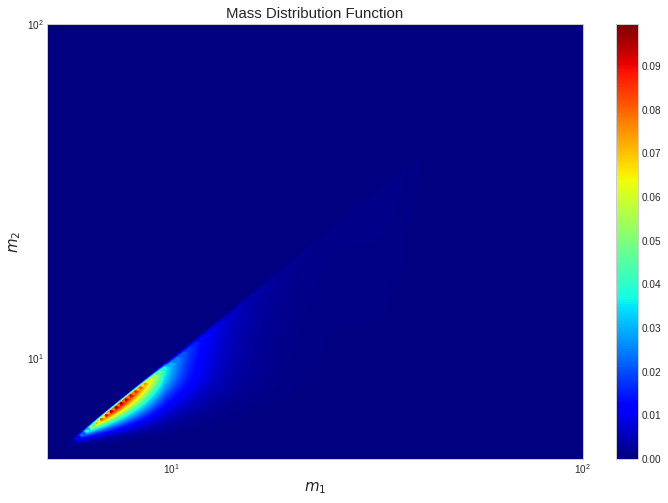

In [29]:
# Colormap of the mass distribution function

Z = np.zeros((int(mass_prec*11/10),int(mass_prec*11/10)))
ran_m1 = np.logspace(np.log10(m_min),np.log10(m_min + 5. - (m_max - (m_min + 5))/mass_prec), int(mass_prec/10))
ran_m1 = np.append(ran_m1, np.linspace(m_min + 5., m_max, mass_prec))
ran_m2 = ran_m1

X, Y = np.meshgrid(ran_m1, ran_m2)

# Mass distribution model B used for the simulation with the values of arxiv 1811.12940

# MassPhaseSpace = ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)

# Mass distribution model C used for the simulation with the values of arxiv 2010.14533

PLPS = PowerLawPS(ran_m1, m_min, m_max, alpha)
GSPS = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m)
q_norm = P2PS(ran_m2, beta_q, m_min, delta_m)
Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, q_norm, 1.)

print('The integrated probability for all possible mass pairs  before normalization is : ', Mass_PS) 

for i in range(len(ran_m1) -1):
    for j in range(len(ran_m2) - 1):
        
        # Value of the colormap for the mass distribuction used in arxiv 1811.12940, it is estimated with a trapezoid formula to avoid singularities in the extremes
        
        # Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
        
        # Value of the colormap for the mass distribuction used in arxiv 2010.14533, it is estimated with a trapezoid formula to avoid singularities in the extremes
        
        Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                            mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
        
        # Fulfill the borders of the colormap by extending the nearest value
        
        if(i == (len(ran_m1) -2)):
            #Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
            Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                                  mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
        if(j == (len(ran_m2) -2)):
            #Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
            Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                                  mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
        
Z[len(ran_m2) - 1][len(ran_m1) -1] = MassDistr(0.5*(X[len(ran_m2) - 1][len(ran_m1) -2] + X[len(ran_m2) - 1][len(ran_m1) -1]),\
                                               0.5*(Y[len(ran_m2) - 2][len(ran_m1) - 1] + Y[len(ran_m2) - 1][len(ran_m1) -1]),\
                                               m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS,\
                                               q_norm[len(ran_m1) -1], Mass_PS)

# Plotting the countour plot

plt.figure(figsize=(12,8))
plt.contourf(X, Y, Z, 250, cmap='jet')
plt.colorbar();
plt.xlabel(r'$m_1$', fontsize = 15)
plt.ylabel(r'$m_2$', fontsize = 15)
plt.title('Mass Distribution Function', fontsize = 15)
plt.loglog()
plt.savefig('MassDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, q_norm, Mass_PS)



print('The integrated probability for all possible mass pairs after normalization is : ', totprob) 

we may also plot the marginalization over $m_2$ to check if we get back the $P(m_1)$ :

In [30]:
Int_Val = np.linspace(0,1,int(mass_prec*11/10))

for i in range(len(ran_m1)):
    Int_Val[i] = 0.
    for j in range(len(ran_m2)-1):
        Int_Val[i] += (ran_m2[j + 1] - ran_m2[j])*Z[j][i]

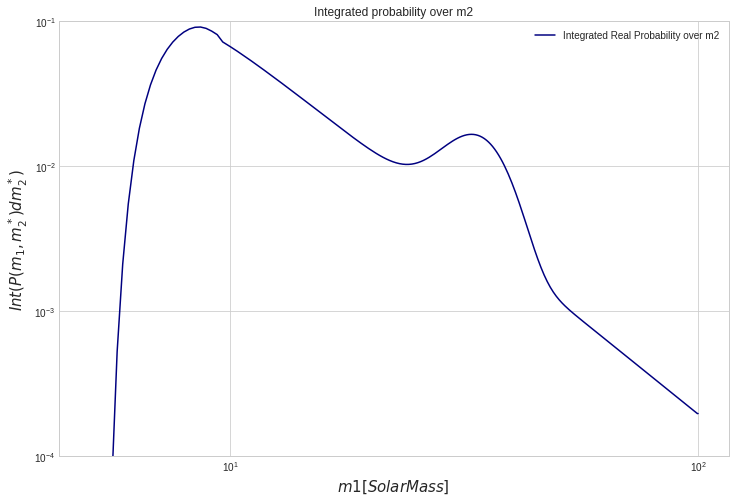

In [31]:
# Plotting the integration of the mass distribution over m2 for each m1

plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
plt.plot(ran_m1, Int_Val, color = 'navy', label = 'Integrated Real Probability over m2')
plt.ylim(10**(-4),0.1)
plt.xlabel('$m1 [Solar Mass]$', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('$Int(P(m_1, m_2^*) dm_2^*) $', fontsize = 15)
plt.title('Integrated probability over m2')
plt.savefig('MarginalizedProbabilityOverM2.png',dpi=500)

For what concerns the spin amplitudes, the colormap will behave as follow :

The integrated probability for all possible spin amplitudes is :  0.9999999999999987


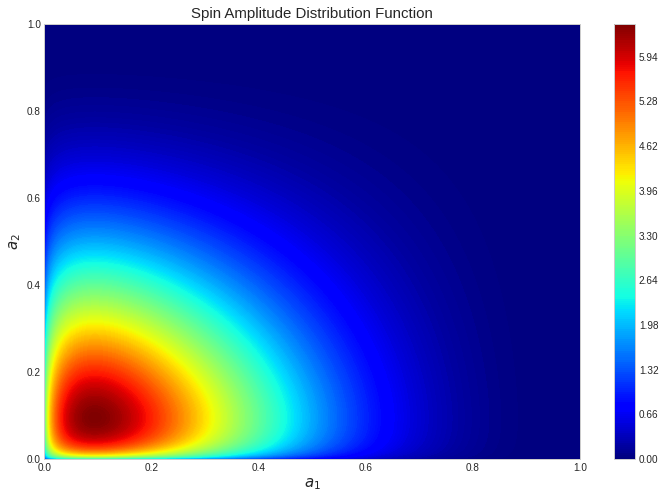

In [32]:
# Colormap of the spin amplitude distribution function, it may be observed the symmetry for swaps among a_1 and a_2

Z = np.zeros((250,250))
ran_a1 = np.linspace(0.,a_max,250)
ran_a2 = np.linspace(0.,a_max,250)
BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
X, Y = np.meshgrid(ran_a1, ran_a2)

for i in range(len(ran_a1) -1):
    for j in range(len(ran_a2) -1):
        Z[j][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        
        # Fulfill the borders of the colormap by extending the nearest value
        
        if(i == (len(ran_a1) -2)):
            Z[j][i+1] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        if(j == (len(ran_m2) -2)):
            Z[j+1][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        
Z[len(ran_a2) - 1][len(ran_a1) -1] = SpinModDistrib(0.5*(X[len(ran_a2) - 1][len(ran_a1)-2] + X[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[len(ran_a2) - 2][len(ran_a1) -1] + Y[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)

# Plotting the countour plot
        
plt.figure(figsize=(12,8))
plt.contourf(X, Y, Z, 250, cmap='jet')
plt.colorbar();
plt.xlabel(r'$a_1$', fontsize = 15)
plt.ylabel(r'$a_2$', fontsize = 15)
plt.title('Spin Amplitude Distribution Function', fontsize = 15)
plt.savefig('SpinAmpDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_a1)-1):
    for j in range(len(ran_a2)-1):
        totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

print('The integrated probability for all possible spin amplitudes is : ', totprob)        

and again, we may plot the marginalization over $a_2$ to check if we get back the $P(a_1)$ :

In [33]:
Int_Val = np.linspace(0,1,250)
for i in range(len(ran_a1)):
    Int_Val[i] = 0.
    for j in range(len(ran_a2)-1):
        Int_Val[i] += (ran_a2[j + 1] - ran_a2[j])*Z[j][i]

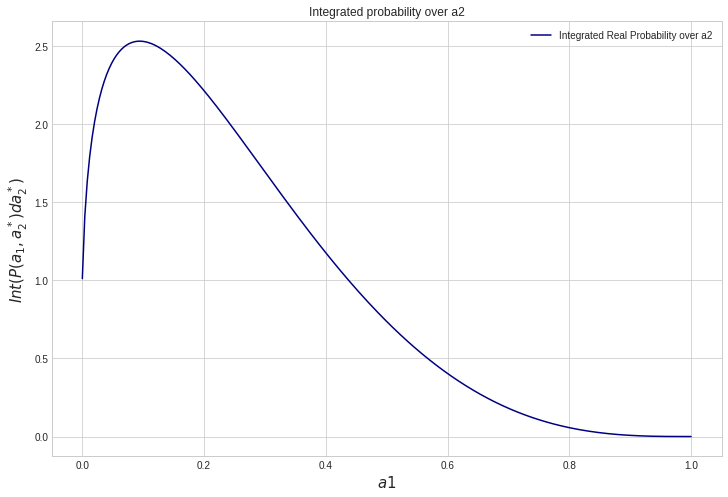

In [34]:
# Plotting the integration of the spin amplitude distribution over a2 for each a1

plt.figure(figsize=(12,8))
plt.plot(ran_a1, Int_Val, color = 'navy', label = 'Integrated Real Probability over a2')
plt.xlabel('$a1$', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('$Int(P(a_1, a_2^*) da_2^*) $', fontsize = 15)
plt.title('Integrated probability over a2')
plt.savefig('MarginalizedProbabilityOverSpinAmplitude2.png',dpi=500)

The last PDF for which the colormaps has to be shown is the Spin tilt distribution, we have :

The integrated probability for all possible tilt angles is :  1.0000005665611968


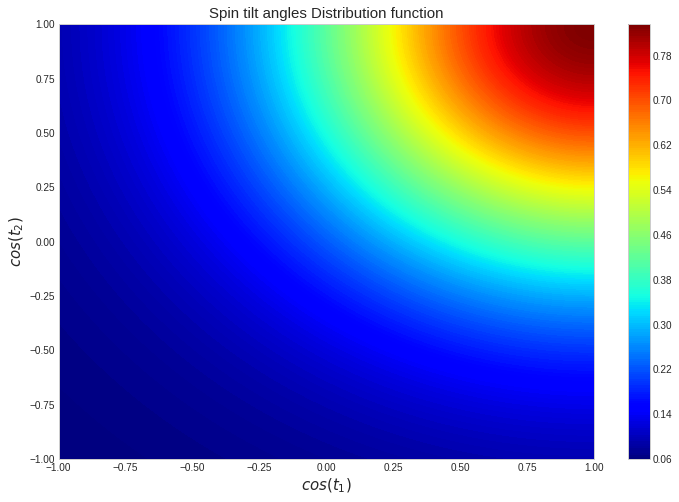

In [35]:
# Colormap of the spin tilt distribution function, it may be observed the symmetry for swap between cos(t1) and cos(t2)

Z = np.zeros((250,250))
ran_cos_t1 = np.linspace(-1.,1.,250)
ran_cos_t2 = np.linspace(-1.,1.,250)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1) -1):
    for j in range(len(ran_cos_t2) -1):
        
        Z[j][i] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)
        
        # Fulfill the borders of the colormap by extending the nearest value
        
        if(i == (len(ran_cos_t1) -2)):
            Z[j][i+1] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)
        if(j == (len(ran_cos_t2) -2)):
            Z[j+1][i] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)
        
Z[len(ran_cos_t2) - 1][len(ran_cos_t1) -1] = SpinOrientDistrib(0.5*(X[len(ran_cos_t2) - 1][len(ran_cos_t1) -2] + X[len(ran_cos_t2) - 1][len(ran_cos_t1) -1]), 0.5*(Y[len(ran_cos_t2) - 2][len(ran_cos_t1) -1] + Y[len(ran_cos_t2) - 1][len(ran_cos_t1) -1]), zeta, sigma_1, sigma_2)

# Plotting the countour plot

plt.figure(figsize=(12,8))
plt.contourf(X, Y, Z, 250, cmap='jet')
plt.colorbar();
plt.xlabel(r'$cos(t_1)$', fontsize = 15)
plt.ylabel(r'$cos(t_2)$', fontsize = 15)
plt.title('Spin tilt angles Distribution function', fontsize = 15)
plt.savefig('SpinTiltDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_cos_t1)-1):
    for j in range(len(ran_cos_t2)-1):
        totprob += (ran_cos_t1[i + 1] - ran_cos_t1[i])*(ran_cos_t2[j + 1] - ran_cos_t2[j])*SpinOrientDistrib(st.mean([ran_cos_t1[i],ran_cos_t1[i + 1]]), st.mean([ran_cos_t2[j],ran_cos_t2[j + 1]]), zeta, sigma_1, sigma_2)

print('The integrated probability for all possible tilt angles is : ', totprob)

which once marginalized over $cos(t_2)$ gives the following $P(cos(t_1))$ :

In [36]:
Int_Val = np.linspace(0,1,250)
for i in range(len(ran_cos_t1)):
    Int_Val[i] = 0.
    for j in range(len(ran_cos_t2)-1):
        Int_Val[i] += (ran_cos_t2[j + 1] - ran_cos_t2[j])*Z[j][i]

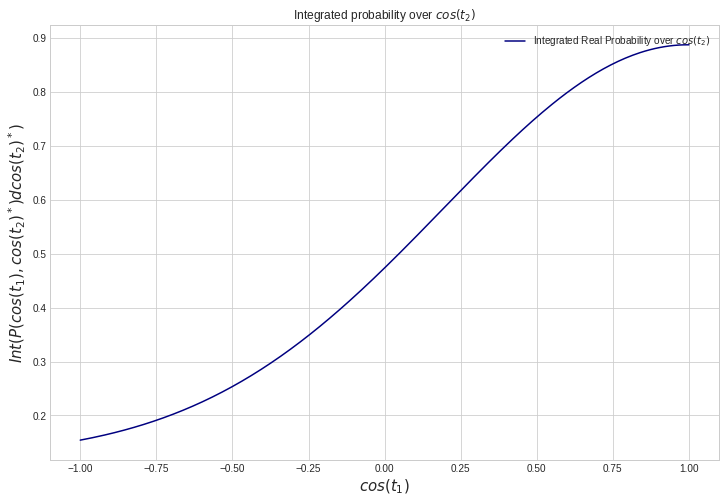

In [37]:
# Plotting the integration of the spin amplitude distribution over a2 for each a1

plt.figure(figsize=(12,8))
plt.plot(ran_cos_t1, Int_Val, color = 'navy', label = 'Integrated Real Probability over $cos(t_2)$')
plt.xlabel('$cos(t_1)$', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('$Int(P(cos(t_1), cos(t_2)^*) d cos(t_2)^*) $', fontsize = 15)
plt.title('Integrated probability over $cos(t_2)$')
plt.savefig('MarginalizedProbabilityOverSpinTilt2.png',dpi=500)

Lastly, the Comoving distance, given the parameters will behave as shown (if $z_{max} <=0.5$ it will be a linear Hubble law) :

In [38]:
ran_z = np.linspace(0.,2.,250)
Dist_lin = ((ran_z*c*(10**(-3)))/(H_0))
Dist_corr = np.linspace(0.,2.,250)
for i in range(len(ran_z)):
    Dist_corr[i] = Z_to_Gpc(ran_z[i]) 

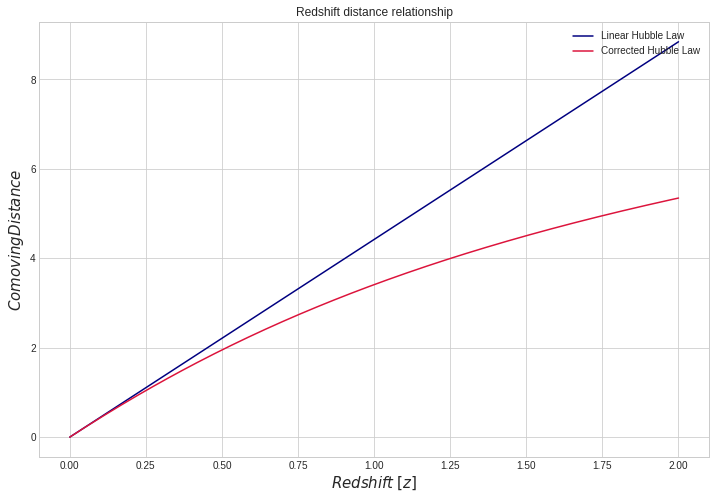

In [39]:
plt.figure(figsize=(12,8))
plt.plot(ran_z, Dist_lin, color = 'navy', label = 'Linear Hubble Law')
plt.plot(ran_z, Dist_corr, color = 'crimson', label = 'Corrected Hubble Law')
plt.xlabel('$Redshift \; [z]$', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('$Comoving Distance$', fontsize = 15)
plt.title('Redshift distance relationship')
plt.savefig('Redshift_Distance.png',dpi=500)

Let's reset the predefined array to avoid RAM consumption :  

In [40]:
X, Y, Z = np.zeros(1),np.zeros(1),np.zeros(1)

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [41]:
# Initialization of the mass phase space

ran_m1 = np.logspace(np.log10(m_min),np.log10(m_min + 5. - (m_max - (m_min + 5))/mass_prec), int(mass_prec/10))
ran_m1 = np.append(ran_m1, np.linspace(m_min + 5., m_max,mass_prec))
ran_m2 = ran_m1
PL_norm = PowerLawPS(ran_m1, m_min, m_max, alpha)
GS_norm = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m) 
q_norm = P2PS(ran_m2, beta_q, m_min, delta_m)
Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, q_norm, 1.)

# Initialization of the distance phase space, we will use a logarithmic scale up to z = 1 and a linear from 1 to z_max

ran_z = np.logspace(np.log10(zmin), np.log10(zmax_log), int(z_prec/10))
ran_z = np.append(ran_z, np.linspace(zmax_log + (ran_z[int(z_prec/10)-1] - ran_z[int(z_prec/10)-2]), zmax_lin, z_prec))

IZCDF ={}

for iz in range(len(ran_z) - 1):
        idx_zmin = (np.abs(zs - ran_z[iz])).argmin()
        idx_zmax = (np.abs(zs - ran_z[iz + 1])).argmin()
        
        ZCDF_slice = ZCDF_samples[idx_zmin:idx_zmax]
        
        # To 0-1 range
        
        ZCDF_slice = (ZCDF_slice - min(ZCDF_slice)) / (max(ZCDF_slice) - min(ZCDF_slice))
        
        # Invert
        
        IZCDF[iz] = interpolate.splrep(ZCDF_slice, zs[idx_zmin:idx_zmax])



and the result will be saved in the BHCat dataframe :

In [42]:
BHCat = pd.DataFrame(columns=['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'InBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

# The Lisa Dataframe instead will be saved without the EventName and will have the following variables and unit of measure 

SOBBHsunits = {

'Redshift': 'Unit',\
    
'Mass1': 'SolarMass',\
    
'Mass2': 'SolarMass',\

'InitialFrequency' : 'Hertz',\
    
'InBandTime' : 'Years',\

'EclipticLongitude' : 'Radian',\
    
'EclipticLatitude' : 'Radian',\
    
'Inclination' : 'Radian',\

'Polarization' : 'Radian',\
    
'InitialPhase' : 'Radian',\
    
'CoalTime' : 'Years',\
    
'Distance' : 'GigaParsec',\

'Spin1' : 'Unit',\
    
'Spin2' : 'Unit',\
    
'AzimuthalAngleOfSpin1' : 'Radian',\
    
'AzimuthalAngleOfSpin2' : 'Radian'    

}

In [43]:
# Example of the format of an added merging event
#BH= pd.DataFrame([[0.2,2 4.6, 18.3, 0.2, 128.5, -0.9, 4.25, 2.4, 1.6, 5.2, 251., 0.8, 0.2, 0.15, -0.2,0.4],], columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate the merging events in the considered volume :

In [44]:
# Checking if flags variable are correct

if((mode_fastmc and mode_ex) or (mode_fastmc and mode_poisson) or (mode_poisson and mode_ex)):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_fastmc !')
    mode_ex = False
    mode_poisson = False
    

if __name__ == '__main__':                                    
    # start the worker processes equals to n_jobs
    print('Percentage of completition : ',0., ' %')
    Nev = Value('i', 0)
    Perc = Value('i', 0)
    Nreal = Value('d', 0.)
    with Pool(processes = n_jobs, initializer = init_globals, initargs = (Nreal,Nev, Perc)) as pool:
        manager = Manager()
        d = manager.list() 
        par_func = partial(Bin_and_Gen, d)
        pool.map(par_func, range(len(ran_m1)-1))
        pool.close()
        pool.join()
                                                       
print('During the simulation, ', Nev.value, ' merging events where generated over the ',int(round(Nreal.value)), ' predicted !')

N_data = len(d)

if(SNR_Cut):
    print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected for low SNR or frequency outisde of the Lisa band')
else:
    print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected as outisde of the Lisa band')

Percentage of completition :  0.0  %
Percentage of completition :  0.36496350364963503 %
Percentage of completition :   0.7299270072992701%
Percentage of completition :  1.094890510948905 %
Percentage of completition :  1.4598540145985401 %
Percentage of completition :  1.8248175182481752 %
Percentage of completition :  2.18978102189781 %
Percentage of completition :  2.5547445255474455 %
Percentage of completition :  2.9197080291970803 %
Percentage of completition :  3.2846715328467155 %
Percentage of completition :  3.6496350364963503 %
Percentage of completition :  4.014598540145985 %
Percentage of completition :  4.37956204379562 %
Percentage of completition :  4.744525547445256 %
Percentage of completition :  5.109489051094891 %
Percentage of completition :  5.474452554744525 %
Percentage of completition :  5.839416058394161 %
Percentage of completition :  6.204379562043796 %
Percentage of completition :  6.569343065693431 %
Percentage of completition :  6.934306569343065 %
Percen

We may now save the generated list to a dataframe and reset the value of said list:


In [45]:
print ('The generated list will now be copied to a dataframe !')
Perc.value = 0
while (len(d) > 0):
    slc_end = int((cp_perc*N_data)+1)
    delta_BH = pd.concat(d[0:slc_end], ignore_index=True)
    del d[0:slc_end]
    BHCat = BHCat.append(delta_BH, sort= False, ignore_index = True)
    Perc.value += 1
    print('Percentage of copying : ',(Perc.value*cp_perc*100),'%')

The generated list will now be copied to a dataframe !
Percentage of copying :  10.0 %
Percentage of copying :  20.0 %
Percentage of copying :  30.000000000000004 %
Percentage of copying :  40.0 %
Percentage of copying :  50.0 %
Percentage of copying :  60.00000000000001 %
Percentage of copying :  70.0 %
Percentage of copying :  80.0 %
Percentage of copying :  90.0 %
Percentage of copying :  100.0 %


and add to the generated dataframe all the missing uniform variables by using fast vectorized operations :


In [46]:
BHCat['Distance'] = (1. + BHCat.Redshift)*Z_to_Gpc(BHCat.Redshift)                                  # Estimate the distance from the redshift using Hubble Law
BHCat['InitialPhase'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi             # Random value between 0 and 2pi
BHCat['InBandTime'] = (1. + BHCat.Redshift)*(BHCat['CoalTime'] - TimeOutFrqRange(BHCat['Mass1'], BHCat['Mass2'], frq_max)) # Estimating the residual time of the event in the LISA frequency band
BHCat['Spin1'] = spinamp_sample(len(BHCat.Mass1), alpha_a, beta_a)            # Drawing spin1 amplitudes from the cumulative inverse function
BHCat['Spin2'] = spinamp_sample(len(BHCat.Mass1), alpha_a, beta_a)            # Drawing spin2 amplitudes from the cumulative inverse function
BHCat['AzimuthalAngleOfSpin1'] = np.arccos(spintilt_sample(len(BHCat.Mass1))) # Drawing spin tilt 1 from the cumulative inverse function
BHCat['AzimuthalAngleOfSpin2'] = np.arccos(spintilt_sample(len(BHCat.Mass1))) # Drawing spin tilt 2 from the cumulative inverse function
BHCat['EclipticLatitude'] = np.arcsin(2 * np.random.random(len(BHCat.Mass1)) - 1)    # Random value between -pi/2 and pi/2
BHCat['EclipticLongitude'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi         # Random value between 0 and 2pi
BHCat['Inclination'] = np.arccos(2 * np.random.random(len(BHCat.Mass1)) - 1)   # Random value between 0 and pi
BHCat['Polarization'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi              # Random value between 0 and 2pi


and we may finally save the complete dataframe :

In [47]:
# Saving the Dataframe

df_key = 'SOBBH'

if(mode_ex):
    df_nm = 'SOBBHCatalogueExotic.h5'        
else:
    if(mode_fastmc):
        df_nm = 'SOBBHCatalogueMC.h5'       
    else:
        df_nm = 'SOBBHCatalogue.h5'
        
BHCat.to_hdf(df_nm, df_key, mode='w')     

<h2> Analysis of the generated catalogue </h2>

Let's load the dataframe and sort by frequency to see over which values the frequencies spanned :

In [48]:
BHCat = pd.read_hdf(df_nm, df_key)
BHCat.sort_values(by=['InitialFrequency'])

,Redshift,Mass1,Mass2,InitialFrequency,InBandTime,EclipticLongitude,EclipticLatitude,Inclination,Polarization,InitialPhase,CoalTime,Distance,Spin1,Spin2,AzimuthalAngleOfSpin1,AzimuthalAngleOfSpin2
29117,0.150542,98.240600,97.551592,0.002005,194.398714,-1.209375,2.334396,1.404312,2.169710,1.056659,194.398793,0.642503,0.367934,0.446356,2.323552,0.546182
29118,0.244159,98.403500,97.827431,0.002110,169.066056,0.759367,0.933653,0.772633,0.767169,2.185180,169.066135,1.018042,0.207224,0.452967,0.651474,1.147811
29084,0.296359,97.132625,93.321180,0.002137,171.885754,-0.673643,2.419455,2.417436,2.952997,3.296275,171.885837,1.219330,0.120709,0.166604,0.892790,1.664602
29057,0.152226,88.576088,88.183553,0.002144,192.862740,1.133049,0.876737,0.738558,1.176401,3.704894,192.862834,0.649420,0.456987,0.209988,1.904338,1.509425
29082,0.162493,91.462066,83.985242,0.002195,183.661803,0.796867,4.671921,2.876315,1.648822,5.746159,183.661898,0.691479,0.755514,0.595375,1.860774,0.274451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,0.231272,12.405449,8.059806,0.154944,0.077458,0.440668,4.935459,1.890216,4.234546,2.051023,0.081020,0.967455,0.221773,0.006903,1.262859,1.837466
23795,0.149369,22.460617,19.912012,0.156936,0.021298,0.827901,3.651899,0.963814,1.025297,5.220014,0.022313,0.637676,0.021547,0.203345,0.673282,1.584072
3996,0.247281,6.647195,6.562190,0.171923,0.114573,-1.390679,1.704141,1.728520,5.812417,0.870212,0.121631,1.030243,0.112302,0.074480,1.169145,1.294347
20523,0.290192,13.797579,9.496421,0.251533,0.014895,0.392916,3.051651,2.487852,5.443486,2.126882,0.017733,1.195852,0.445257,0.182831,2.341081,1.464469


The redshift distribution of the generated dataframe is as follows :

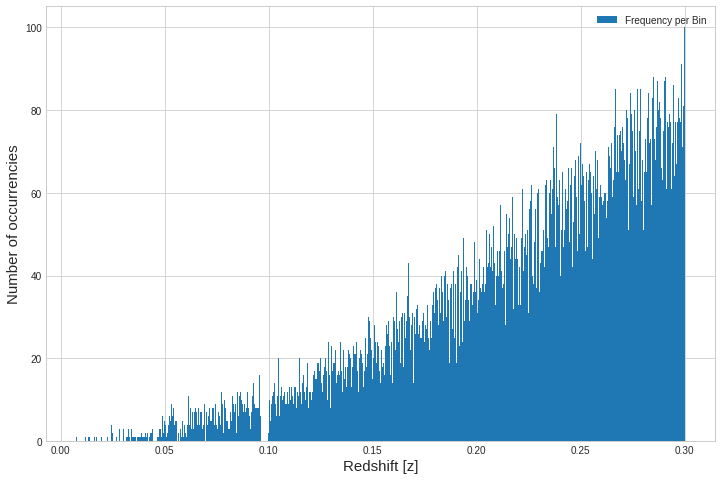

In [49]:
plt.figure(figsize=(12,8))
plt.hist(BHCat['Redshift'], bins = 250, label = 'Frequency per Bin')
plt.xlabel('Redshift [z]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('RedshiftDistrib.png',dpi=500)

To check that the generated dataframe is following the density distributions, let's plot a scatter plot of the masses, together with their marginalized histograms :

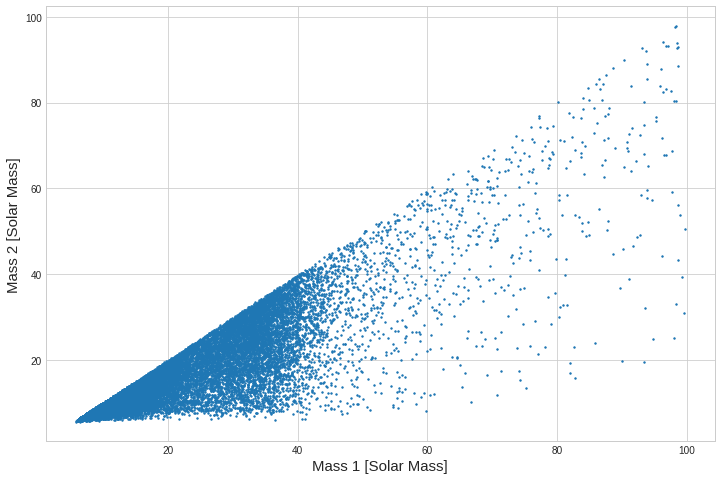

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Mass1'], BHCat['Mass2'], s=2)
plt.xlabel('Mass 1 [Solar Mass]', fontsize = 15)
plt.ylabel('Mass 2 [Solar Mass]', fontsize = 15)
plt.savefig('MassesScatterplot.png',dpi=500)

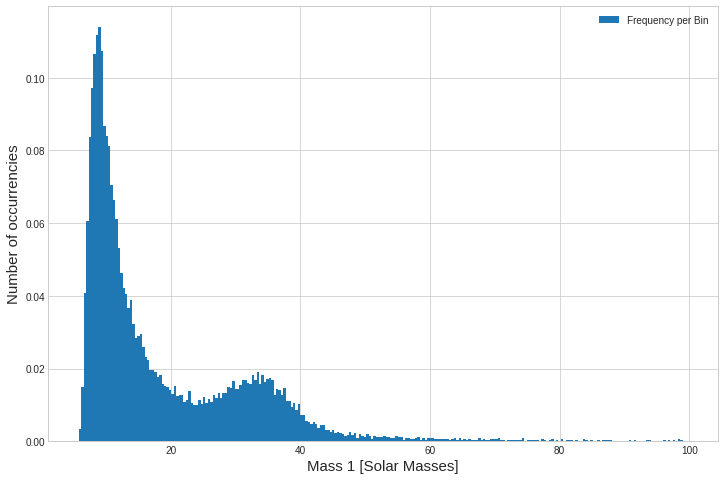

In [51]:
plt.figure(figsize=(12,8))
plt.hist(BHCat['Mass1'], bins = mass_prec, label = 'Frequency per Bin', density = True)
plt.xlabel('Mass 1 [Solar Masses]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Mass_1_Hist.png',dpi=500)

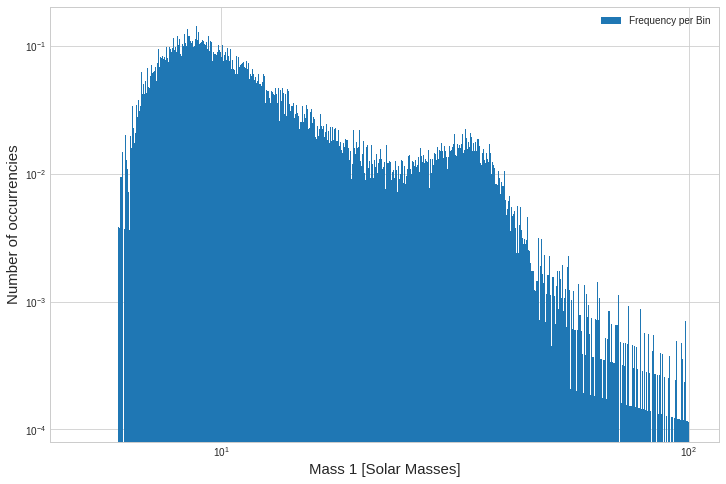

In [52]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(np.log10(m_min),np.log10(m_max),1000)
plt.hist(BHCat['Mass1'], bins = log_bin, label = 'Frequency per Bin', density = True)
plt.xlabel('Mass 1 [Solar Masses]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Mass_1_Hist_log.png',dpi=500)

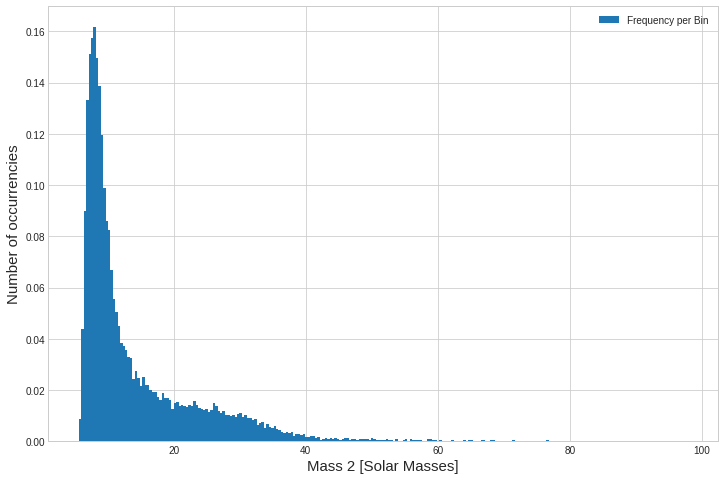

In [53]:
plt.figure(figsize=(12,8))
plt.hist(BHCat['Mass2'], bins = mass_prec, label = 'Frequency per Bin', density = True)
plt.xlabel('Mass 2 [Solar Masses]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Mass_2_Hist.png',dpi=500)

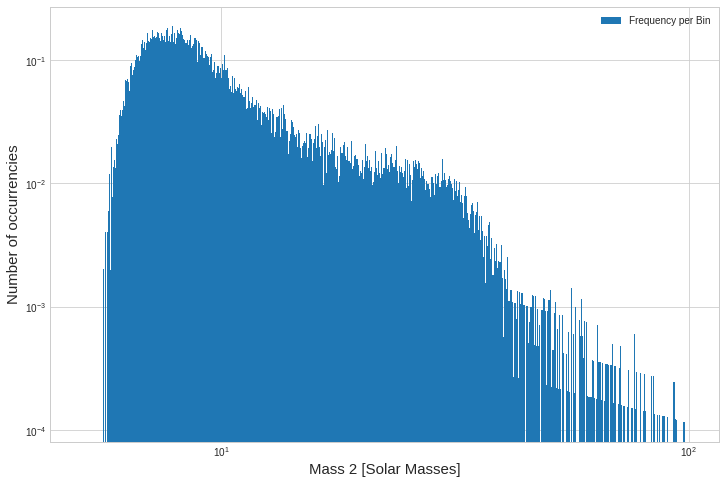

In [54]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(np.log10(m_min),np.log10(m_max),1000)
plt.hist(BHCat['Mass2'], bins = log_bin, label = 'Frequency per Bin', density = True)
plt.xlabel('Mass 2 [Solar Masses]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Mass_2_Hist_log.png',dpi=500)

Together with a scatter plot for the spin amplitude and orientation:


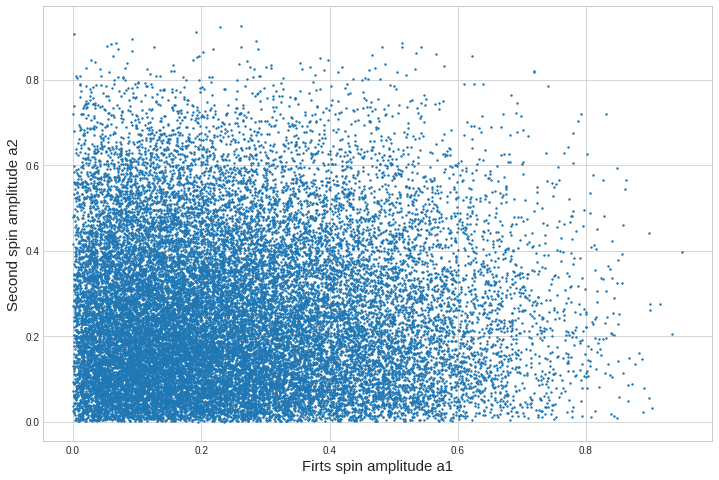

In [55]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Spin1'], BHCat['Spin2'], s=2)
plt.xlabel('Firts spin amplitude a1', fontsize = 15)
plt.ylabel('Second spin amplitude a2', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)
plt.savefig('SpinAmplitudesScatterplot.png',dpi=500)

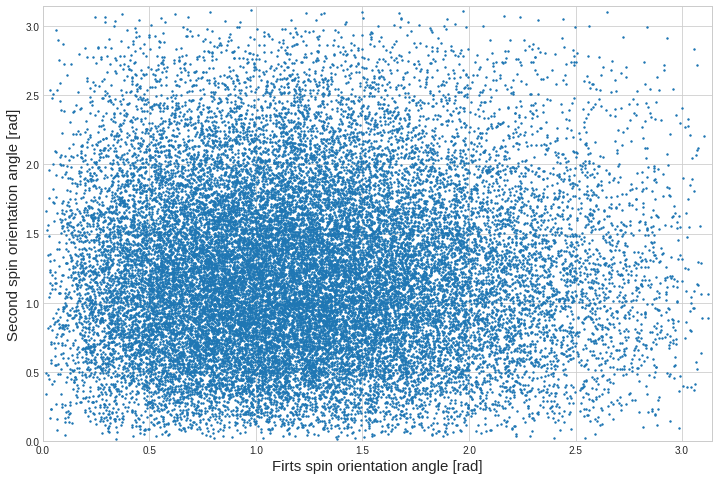

In [56]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['AzimuthalAngleOfSpin1'], BHCat['AzimuthalAngleOfSpin2'], s=2)
plt.xlabel('Firts spin orientation angle [rad]', fontsize = 15)
plt.ylabel('Second spin orientation angle [rad]', fontsize = 15)
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)
plt.savefig('SpinTiltsScatterplot.png',dpi=500)

and their corrispettive histograms, we will plot only the ones for the bigger mass BH as it would be the same for the lower mass :

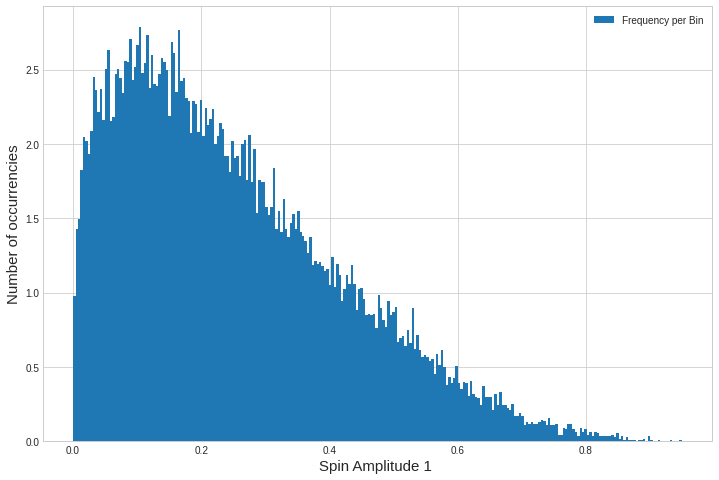

In [57]:
plt.figure(figsize=(12,8))
plt.hist(BHCat['Spin1'], bins = 250, label = 'Frequency per Bin', density = True)
plt.xlabel('Spin Amplitude 1 ', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Spin_Ampl_1_Hist.png',dpi=500)

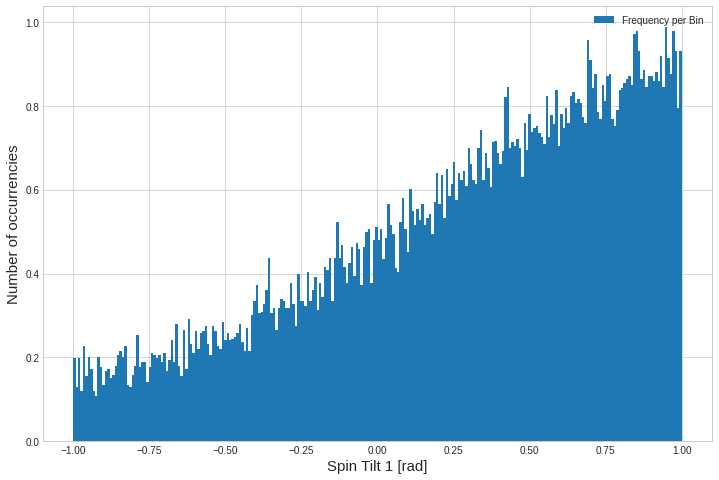

In [58]:
plt.figure(figsize=(12,8))
plt.hist(np.cos(BHCat['AzimuthalAngleOfSpin1']), bins = 250, label = 'Frequency per Bin', density = True)
plt.xlabel('Spin Tilt 1 [rad]', fontsize = 15 )
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('Spin_Tilt_1_Hist.png',dpi=500)

Finally, the properties of the generated dataframe may be observed from an histogram of the frequencies :

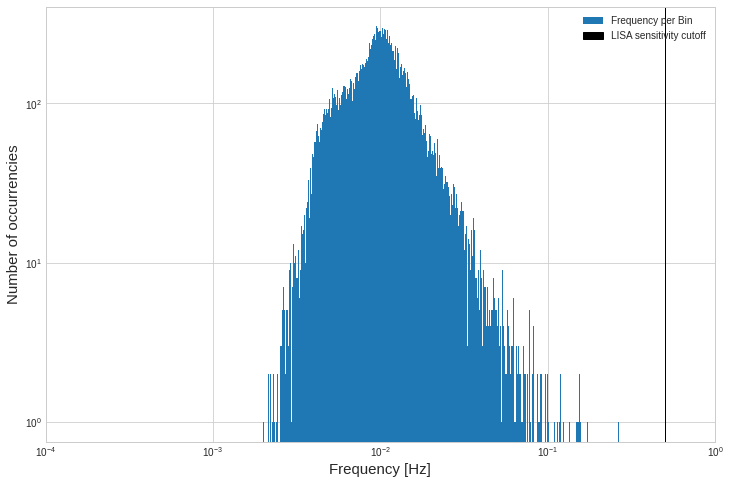

In [59]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,0,1000)
plt.hist(BHCat['InitialFrequency'], bins = log_bin, label = 'Frequency per Bin')
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.xlim(10**(-4),1)
plt.axvspan(frq_max-0.001, frq_max + 0.001, 0, 1, color = 'black', label = 'LISA sensitivity cutoff')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)

and an hystogram showing the time of each event inside the LISA band :

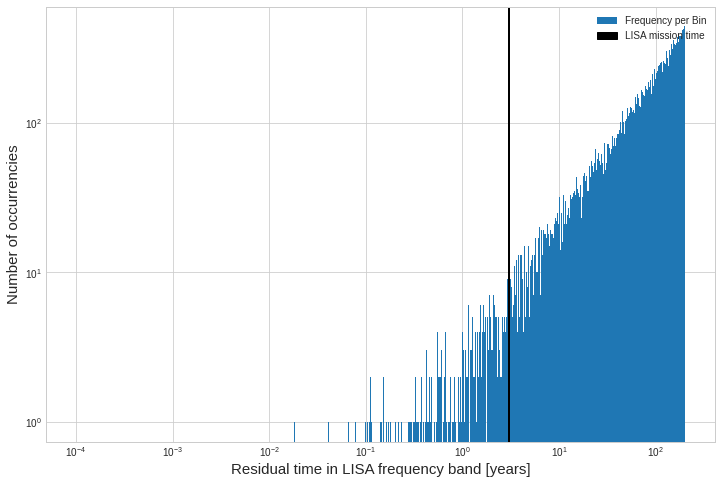

In [60]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,np.log10(max_tc),1000)
plt.hist(BHCat['InBandTime'], bins = log_bin, label = 'Frequency per Bin')
plt.xlabel('Residual time in LISA frequency band [years]', fontsize = 15 )
plt.axvspan(T_obs - 0.01, T_obs + 0.01, 0, 1, color = 'black', label = 'LISA mission time')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('TimeInFrequencyBand.png',dpi=500)

<h2> Saving the catalogue in the LISA format </h2>

Lastly, let's convert the dataframe to the standard LISA type dataframe :

In [61]:
#LH = LISAhdf5('LISA'+df_nm)
#pr = ParsUnits()

#for p in list(SOBBHsunits.keys()):
#    pr.addPar(p,BHCat[p],SOBBHsunits[p])

#pr.addPar("SourceType",df_key, "name")    
#LH.addSource('SOBBH',pr, overwrite=True)   
